## Mean-Variance Optimization with risky asset and cash

## Purpose:

* Reinforcement learning is applied to the problem of optimal allocation
* The least squares policy iteration (LSPI) algorithm is applied to a Monte Carlo simulation of a stock's price movements, constructing a basis over the state-action space using B-spline basis functions at each time period.
* The optimal Q-function is approximated with a dynamic programming approach, and this is shown to approach the exact solution

In [1]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import norm

from bspline import Bspline, splinelab

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters for MC simulation of stock prices

In [2]:
S0 = 100 # Initial stock price
mu = 0.03 # Drift
sigma = 0.20 # Volatility
r = 0.01 # Risk-free rate
M = 1 # Maturity

T = 30 # Number of time steps
delta_t = M / T # Time interval

N_MC = 2000 # Number of paths

gamma = np.exp(- r * delta_t) # Discount factor
lmbda = 10.0 # Risk aversion
alpha = 1.0 # Learning rate

## Create dataset

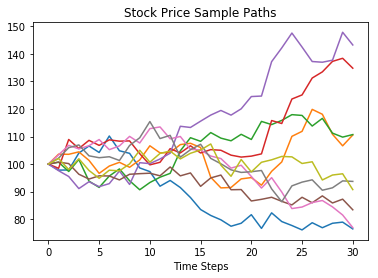

In [3]:
# Stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:, 0] = S0

# Standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC, T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:, t] = S.loc[:, t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:, t])
    
    # Or, using Euler for alpha-stable distributions:
    #S.loc[:, t] = S.loc[:, t-1]*(1 + mu*delta_t + sigma *S.loc[:,t-1]**(alpha-1)*np.sqrt(delta_t) * RN.loc[:,t])

# Plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()


$$C_t = -R_t= -r_t  + \lambda (r_t-\mu)^2  =  -(1-u_t)r_f - u_t  \phi_t  +  \lambda u_t^2 Var(\phi_t | S_t)$$ 

In [4]:
def negative_reward(mu, var, a, rf, lmbda):
    C = -(1-a)*rf - a*mu + lmbda*(a**2)*var
    return C

##  Define spline basis functions  

In [5]:
X = S # set the wealth (but not the total wealth) of the portfolio to be the stock price
p = 4 # order of spline (as-is; 3 = cubic, 4: B-spline)
ncolloc = 16
a_min = -1
a_max = 1

In [6]:
def get_basis_functions(X_min, X_max, a_min, a_max, ncolloc, p=3):
    tau_x = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we
    tau_a = np.linspace(a_min, a_max, ncolloc)  # would like to interpolate

    # k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
    # To get meaninful results, one should have ncolloc >= p+1
    k_x = splinelab.aptknt(tau_x, p)
    k_a = splinelab.aptknt(tau_a, p)
                             
    # Spline basis of order p on knots k
    basis_x = Bspline(k_x, p)
    basis_a = Bspline(k_a, p)
    return basis_x, basis_a

### Make data matrices with feature values

"Features" here are the values of basis functions at data points
The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [7]:
num_t_steps = T + 1
num_basis =  ncolloc**2 

data_mat_t = np.zeros((num_t_steps, N_MC, num_basis ))

In [8]:
x = X.values[:, 0]
np.shape(x)

(2000,)

## Compute the optimal Q-function with the DP approach 

Coefficients for expansions of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ are solved by

$$W_t=\mathbf S_t^{-1}\mathbf M_t$$

where $\mathbf S_t$ and $\mathbf M_t$ are matrix and vector respectively with elements given by

$$S_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\Phi_m\left(X_t^k,a_t^k\right)}\quad\quad M_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\left(C\left(X_t^k,a_t^k,X_{t+1}^k\right)+\gamma\min_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1}^k,a_{t+1}^k\right)\right)}$$

Define function *function_S* and *function_M* to compute the value of matrix $\mathbf S_t$ and vector $\mathbf M_t$.

In [9]:
def function_S_vec(t, data_mat_t):
    # Compute the matrix S_{nm} 
    X_mat = data_mat_t[t, :, :]
    num_basis_funcs = X_mat.shape[1]    
    S_mat = np.dot(X_mat.T, X_mat)
    return S_mat

def function_M_vec(t, Q, R, data_mat_t, gamma=0.1):
    X_mat = data_mat_t[t,:,:]
    tmp = R + gamma * np.min(Q[:, t+1])  # note that the second argument in Q is t+1
    M = np.dot(X_mat.T, tmp)
    return M

### Least Squares Policy Iteration
Call *function_S* and *function_M* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t,a_t\right)$ to compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t,a_t^\star\right)}$ backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=0$.



#### Initialize data structures

In [10]:
mu = np.zeros(T)
var = np.zeros(T)

# optimal action
a_opt = np.zeros((N_MC, T))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:, -1] = 0

# optimal Q-function with optimal action
max_Q_star = np.zeros((N_MC, T))

a_mean = []

#### initialize actions in feasible region [0, a_max]

In [11]:
grid_size_x = 20
grid_size_a = 500 

# set up a small grid, sufficiently nested inside the support of the basis functions
a_min_prime = a_min + 0.1
a_max_prime = a_max - 0.1

a_grid = np.linspace(a_min_prime, a_max_prime, grid_size_a)

Q_star = np.zeros((N_MC, T))
tau = 1e-6
a = a_min_prime + (a_max_prime - a_min_prime) * np.random.rand(N_MC)

There are *grid_size_x* $\times$ *grid_size_a* inner grid points and 256 basis functions. Let $(k,l)$ denote the indices of the smaller grid $\Omega^h$. Let $(i,j)$ denote the indices of the knot points of the basis functions. If you sum over the last index, then you can check the interpolation of ones
$$f(x_k,a_l)=\sum_{ij} \Phi(x_k,a_l)f_{ij}$$
check if $f_{ij}=1$ everywhere
$$f(x,a)=\sum_{ij} \Phi(x,a)1 =1, \forall x,a ?$$

#### The backward loop

*Make sure to rerun cells under the heading* **'Initialize data structures'** *to reset the initial conditions before running this cell*

In [15]:
for t in np.arange(T - 2, 0, -1):
    error = tau
    q_prev = np.zeros(N_MC)  
    ret = (S.loc[:, t+1] - S.loc[:, t]) / S.loc[:, t]
    mu[t] = np.mean(ret)
    var[t] = np.var(ret)
    count = 0
    max_iter = 100
    x = X.values[:, t]
    basis_x, basis_a = get_basis_functions(np.min(x)-10, np.max(x)+10, a_min, a_max, ncolloc, p)
    x_grid = np.linspace(np.min(x), np.max(x), grid_size_x)
    Phi_mat = np.array([[np.kron(basis_x(x_grid[i]), basis_a(a_grid[j])).reshape(num_basis, 1) 
                         for i in range(grid_size_x)] for j in range(grid_size_a)])[:, :, :, 0]   
        
    while (np.abs(error)>=tau) and (count<max_iter):
       
        R = negative_reward(mu[t], var[t], a, r, lmbda)
        data_mat_t[t, :, :] = np.array([np.kron(basis_x(x[i]), basis_a(a[i])).reshape(num_basis, 1) for i in range(N_MC)])[:, :, 0]
        
        # Check partition of unity
        h = np.dot(data_mat_t[t],np.ones(np.shape(data_mat_t[t])[1]))
        if np.sum(h) != N_MC:
            print("error: loss of partition of unity")
        S_t = function_S_vec(t, data_mat_t) 
        M_t = function_M_vec(t, Q_star, R, data_mat_t, gamma)
        W_t = np.dot(np.linalg.pinv(S_t), M_t)
       
        # Compute Q_t matrix over small grid
        # Phi_mat is the matrix for interpolating over the smaller x * a grid
        Q_t = np.dot(Phi_mat, W_t) # gridded Q_t
        
        print("residual error: ||r||=||Sw-M||")
        print(np.linalg.norm(np.dot(S_t, W_t) - M_t))
        
        # Find the optimal action on the small grid
        a_idx =  np.argmin(Q_t, axis=0)
        # Need to interpolate over X 
        a_star_ = np.zeros(grid_size_x, dtype='float64')
        
        for j in range(grid_size_x):
            a_star_[j] = a_grid[a_idx[j]]
    
        f = interp1d(x_grid, a_star_, kind='cubic')
        a_prime = f(x)
        
        # Only update the actions along the paths where the neg. reward is lowered
        R_prime = negative_reward(mu[t], var[t], a_prime, r, lmbda)
        idx = np.where(R_prime>R)
        a_prime[idx] = a[idx]
        a = a_prime
        a_mean.append(np.mean(a))
        Q_star[:,t] = np.dot(data_mat_t[t, :, :], W_t)
        error = np.linalg.norm(Q_star[:, t] - q_prev)
        
        q_prev = np.copy(Q_star[:, t])
        
        print('count, Q error, E[R], E[a]')
        print(count, error, np.mean(R), np.mean(a))
        count += 1 
       
    a_opt[:, t] = a  

residual error: ||r||=||Sw-M||
4.054087113470703e-09
count, Q error, E[R], E[a]
0 0.39985090486548763 -0.0064244171795789255 -0.38409046036259487
residual error: ||r||=||Sw-M||
0.0016271308689962385
count, Q error, E[R], E[a]
1 0.37221550157859185 -0.011958626753660277 -0.38419634873003156
residual error: ||r||=||Sw-M||
0.001724869490438883
count, Q error, E[R], E[a]
2 0.00043257994172365814 -0.01195880276161595 -0.38427276043711833
residual error: ||r||=||Sw-M||
0.000686165596517034
count, Q error, E[R], E[a]
3 0.0001865506479181699 -0.01195880336297234 -0.3842866140073686
residual error: ||r||=||Sw-M||
0.0008138967279655943
count, Q error, E[R], E[a]
4 0.00013478255458155967 -0.011958803475966265 -0.3842884727274255
residual error: ||r||=||Sw-M||
0.0002586494714753655
count, Q error, E[R], E[a]
5 8.904912691955464e-05 -0.011958808239279702 -0.3842902778013504
residual error: ||r||=||Sw-M||
0.0003211161745436431
count, Q error, E[R], E[a]
6 5.2007692918097614e-05 -0.011958812829682598

residual error: ||r||=||Sw-M||
3.3233991785938706e-05
count, Q error, E[R], E[a]
5 0.00013285191576742122 -0.011648649493199397 -0.34512906301794893
residual error: ||r||=||Sw-M||
2.3042502172395993e-05
count, Q error, E[R], E[a]
6 2.370332169790823e-05 -0.011648690938317607 -0.3451208137791208
residual error: ||r||=||Sw-M||
3.7159421208453256e-05
count, Q error, E[R], E[a]
7 7.356768655097124e-06 -0.011648695985750232 -0.34511570478606085
residual error: ||r||=||Sw-M||
6.23682055136617e-05
count, Q error, E[R], E[a]
8 6.444158676366542e-06 -0.011648696203050833 -0.34511570478606085
residual error: ||r||=||Sw-M||
6.23682055136617e-05
count, Q error, E[R], E[a]
9 0.0 -0.011648696203050833 -0.34511570478606085
residual error: ||r||=||Sw-M||
7.945324456164468e-06
count, Q error, E[R], E[a]
0 3.1434532954596883 -0.01130923374135247 -0.3236553212599598
residual error: ||r||=||Sw-M||
0.03494810469257471
count, Q error, E[R], E[a]
1 0.0038938493505896324 -0.011323607472175987 -0.3190316732917

residual error: ||r||=||Sw-M||
0.0017270164667982143
count, Q error, E[R], E[a]
9 0.00016886591472191267 -0.011684435369819156 -0.34859467764802066
residual error: ||r||=||Sw-M||
8.43828086600416e-05
count, Q error, E[R], E[a]
10 0.00017053490707780086 -0.011684438674136032 -0.34859492970056927
residual error: ||r||=||Sw-M||
0.00015526364382177182
count, Q error, E[R], E[a]
11 1.8927195217583547e-05 -0.01168443870902257 -0.34859492970056927
residual error: ||r||=||Sw-M||
0.00015526364382177182
count, Q error, E[R], E[a]
12 0.0 -0.01168443870902257 -0.34859492970056927
residual error: ||r||=||Sw-M||
9.311849903561253e-05
count, Q error, E[R], E[a]
0 4.702174397606315 -0.011755081159362156 -0.35529058940908365
residual error: ||r||=||Sw-M||
0.006182641511297971
count, Q error, E[R], E[a]
1 0.0006994371079297109 -0.011756715531787055 -0.3553006297154633
residual error: ||r||=||Sw-M||
0.018427415285904157
count, Q error, E[R], E[a]
2 0.0029567335952147126 -0.011756717715441905 -0.355964789

residual error: ||r||=||Sw-M||
0.00261553494522653
count, Q error, E[R], E[a]
2 0.0005574445722658425 -0.011460194718865762 -0.33145925488242844
residual error: ||r||=||Sw-M||
0.0003907640554730167
count, Q error, E[R], E[a]
3 0.0003156654652824479 -0.011461427818005007 -0.32883962776358566
residual error: ||r||=||Sw-M||
0.001673669599611927
count, Q error, E[R], E[a]
4 0.00023497087533933596 -0.011461686556107301 -0.3294739306934683
residual error: ||r||=||Sw-M||
0.0019278533605981798
count, Q error, E[R], E[a]
5 0.00029862606873591325 -0.011461748733628603 -0.32946495321252917
residual error: ||r||=||Sw-M||
0.0007457293156077845
count, Q error, E[R], E[a]
6 0.00022385381796159306 -0.011461751265319979 -0.32946507270684716
residual error: ||r||=||Sw-M||
0.0017730768898527442
count, Q error, E[R], E[a]
7 0.0002063753369778312 -0.011461751269530827 -0.32950306018366826
residual error: ||r||=||Sw-M||
0.0019737433820017475
count, Q error, E[R], E[a]
8 0.00033240649951809143 -0.01146175861

residual error: ||r||=||Sw-M||
0.001381674336522486
count, Q error, E[R], E[a]
10 0.0011768985427297444 -0.011079403667371902 -0.2831428632823293
residual error: ||r||=||Sw-M||
0.002006336930411817
count, Q error, E[R], E[a]
11 0.0003027298417763846 -0.011079505530138032 -0.2823866797716928
residual error: ||r||=||Sw-M||
0.006795153079861341
count, Q error, E[R], E[a]
12 0.0007050273840174087 -0.01107952052031704 -0.28103672791763334
residual error: ||r||=||Sw-M||
0.003910031011944382
count, Q error, E[R], E[a]
13 0.0006481441904449657 -0.01107960541529135 -0.28000583568371906
residual error: ||r||=||Sw-M||
0.12286103908920414
count, Q error, E[R], E[a]
14 0.012778685480832648 -0.011079772712891227 -0.2800031776511989
residual error: ||r||=||Sw-M||
0.02464335163578047
count, Q error, E[R], E[a]
15 0.01500204787763564 -0.011079772804964015 -0.27994033788555567
residual error: ||r||=||Sw-M||
0.01835007809712463
count, Q error, E[R], E[a]
16 0.0036624355363651254 -0.011079775587825297 -0.

residual error: ||r||=||Sw-M||
0.010988386438905526
count, Q error, E[R], E[a]
9 0.0011671233889318344 -0.011203058046953738 -0.3046492200090265
residual error: ||r||=||Sw-M||
0.007227526419270682
count, Q error, E[R], E[a]
10 0.001735050277674186 -0.011203595377091488 -0.2929720274557239
residual error: ||r||=||Sw-M||
0.024516796914529498
count, Q error, E[R], E[a]
11 0.001978381401777481 -0.011206537002986256 -0.2929648130268663
residual error: ||r||=||Sw-M||
0.015601743998120515
count, Q error, E[R], E[a]
12 0.0017770979798986493 -0.011206538068954419 -0.29289185998705625
residual error: ||r||=||Sw-M||
0.040684829647864115
count, Q error, E[R], E[a]
13 0.0034889700618370087 -0.011206539809694764 -0.29290528245340625
residual error: ||r||=||Sw-M||
0.09237278894002196
count, Q error, E[R], E[a]
14 0.013731953031973635 -0.01120655527562437 -0.29289833984273367
residual error: ||r||=||Sw-M||
0.016236605771745946
count, Q error, E[R], E[a]
15 0.009084380921888426 -0.011206555408135525 -0

residual error: ||r||=||Sw-M||
0.0024515408158344385
count, Q error, E[R], E[a]
10 0.0004278633108513567 -0.011574853041324502 -0.33343431394612494
residual error: ||r||=||Sw-M||
0.0023921696001492003
count, Q error, E[R], E[a]
11 0.0003259623092063793 -0.011574853670854594 -0.3334289896431571
residual error: ||r||=||Sw-M||
0.00667394802935473
count, Q error, E[R], E[a]
12 0.0007435484657782206 -0.011574853686081923 -0.3334281746785153
residual error: ||r||=||Sw-M||
0.007066002765180291
count, Q error, E[R], E[a]
13 0.0006530633482579014 -0.01157485368902071 -0.33340432481984544
residual error: ||r||=||Sw-M||
0.005713235712635963
count, Q error, E[R], E[a]
14 0.0010387744633322013 -0.011574853760295685 -0.3334033729691346
residual error: ||r||=||Sw-M||
0.002607176368327692
count, Q error, E[R], E[a]
15 0.0006038403008173356 -0.011574853764351311 -0.33340549551966403
residual error: ||r||=||Sw-M||
0.0029643559589351376
count, Q error, E[R], E[a]
16 0.0005316236484042865 -0.0115748538954

residual error: ||r||=||Sw-M||
0.0072423870053955385
count, Q error, E[R], E[a]
7 0.001100242493296044 -0.011287044811734552 -0.31732460806806023
residual error: ||r||=||Sw-M||
0.0016868608868680606
count, Q error, E[R], E[a]
8 0.0008754515332217769 -0.011287181085645222 -0.3135422395680505
residual error: ||r||=||Sw-M||
0.01142178203379157
count, Q error, E[R], E[a]
9 0.0014677100222630797 -0.011287782025755602 -0.3120814069660814
residual error: ||r||=||Sw-M||
0.009736772817420252
count, Q error, E[R], E[a]
10 0.0011488703859781012 -0.011288083872358709 -0.31052271572685336
residual error: ||r||=||Sw-M||
0.03020887611654973
count, Q error, E[R], E[a]
11 0.0037732432910729035 -0.011288321521750098 -0.30970334350049156
residual error: ||r||=||Sw-M||
0.020091624276342618
count, Q error, E[R], E[a]
12 0.001316214481424766 -0.011288392775722045 -0.30929394934312887
residual error: ||r||=||Sw-M||
0.0164815103261339
count, Q error, E[R], E[a]
13 0.002610711405433097 -0.011288471539966368 -0

KeyboardInterrupt: 

In [ ]:
a_star_exact = []
a_star_approx = []
for t in range(1, T-1):
    a_star_exact.append((mu[t] - r) / (2 * lmbda * var[t]))
    a_star_approx.append(np.mean(a_opt[:, t]))

In [ ]:
plt.plot(a_star_approx)
plt.plot(a_star_exact, color='red')
plt.xlabel('time')
plt.ylabel('action');

In [ ]:
a_star_exact = (mu[t] - r) / (2 * lmbda * var[t])

In [ ]:
a_star_exact

In [ ]:
negative_reward(mu[t], var[t], a_star_exact, r, lmbda)

In [ ]:
a_ = np.arange(-1, 1, 0.01)
plt.plot(a_, negative_reward(mu[t], var[t], a_, r, lmbda))
plt.xlabel('S')
plt.ylabel('R');

In [ ]:
plt.plot(a_mean)
plt.plot(x_grid, a_star_)
plt.plot(x_grid, np.ones(len(x_grid)) * a_star_exact, color='black')
plt.ylim([-1, 1])

optimal action depends on lambda